#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import parallel_driver
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os

os.chdir(r'/Users/jpnousu/SpaFHy_v2.0')

'''
# example how to run a single catchment
folder = '/Users/jpnousu/SpaFHy_RUNS/krycklan'
catchment = 'krycklan'

outputfile = parallel_driver(catchment, catchment_no=16, create_ncf=True, create_spinup=False, output=True, folder=folder)
'''

# example how to run multiple catchments in parallel
folder = '/Users/jpnousu/SpaFHy_RUNS/krycklan'
catchment = 'krycklan'

catchment_no = np.arange(1,23,1)
exclude = [11, 17, 18, 19]
catchment_no = np.setdiff1d(catchment_no, exclude)

outputfile = parallel_driver(catchment, catchment_no, create_ncf=True, create_spinup=False, output=True, folder=folder)

# Reading the .nc results file that was created
results = xr.open_dataset(outputfile[0])

*** Catchment no.: 2 ***
*** Catchment no.: 1 ***
*** Catchment no.: 3 ***
*** Catchment no.: 10 ***
*** Catchment no.: 5 ***
*** Catchment no.: 8 ***
*** Catchment no.: 7 ***
*** Catchment no.: 13 ***
*** Catchment no.: 4 ***
*** Catchment no.: 12 ***
*** Catchment no.: 6 ***
*** Catchment no.: 9 ***
*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {8.0, 3.0, 6.0} ***
*** Defined organic soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used organic soil IDs: {8.0, 3.0, 6.0} ***
*** Defined deep soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used soil IDs: {8.0, 3.0, 6.0}
*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {8.0} ***
*** Defined organic soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used organic soil IDs: {8.0} ***
*** Defined deep soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used soil IDs: {8.0}
*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {1.0, 3.0, 5.0, 7.0, 8.0} ***
**

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: Runt

Running timestep:  11
 , H[max_index]: 0.0003923847173723516
Running timestep:  77
Timestep: 12 , iterations: 5 , conv1: 0.00042034128483692257 , H[max_index]: 0.0018086485559365428
Timestep: 77 , iterations: 3 , conv1: 0.0009096178031882118 , H[max_index]: 0.00035974308866570937
Running timestep:  78
Running timestep:  13Timestep: 11 , iterations: 3 , conv1: 0.0005921591816786531 , H[max_index]: 0.0030312038305169153

Running timestep:  4
Timestep: 78 , iterations: 3 , conv1: 0.0008829213197145691 , H[max_index]: 0.0003279065508650092
Running timestep:  12
Running timestep:  79
Timestep: 79 , iterations: 2 , conv1: 0.0009796482827937325 , H[max_index]: 0.0011508986306694169
Timestep: 11 , iterations: 5 , conv1: 0.0006702416621919838 , H[max_index]: 0.0010728959496191237
Running timestep:  80
Running timestep:  12
Timestep: 80 , iterations: 2 , conv1: 0.0009381427621519833 , H[max_index]: 0.001091270503479791
Running timestep:  81
Timestep: 28 , iterations: 4 , conv1: 0.000740444233599

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 18 , iterations: 8 , conv1: 0.0004077384662082295 , H[max_index]: 0.0006099726649608783
Timestep: 115 , iterations: 4 , conv1: 0.0007920186510546046 , H[max_index]: 0.001687733109747569
Timestep: 23 , iterations: 4 , conv1: 0.0008331152730818303 , H[max_index]: 0.0014709048782037826
Timestep: 23 , iterations: 4 , conv1: 0.0006735082602062903 , H[max_index]: 0.0021989776607256317
Running timestep:  116
Running timestep:  19
Running timestep:  14
Running timestep:  4
Running timestep:  24
Timestep: 4 , iterations: 2 , conv1: 0.00012417533207553788 , H[max_index]: -0.573382421353017
Running timestep:  24
Timestep: 116 , iterations: 4 , conv1: 0.0007988476403397726 , H[max_index]: 0.0016338471492645112
Running timestep:  117
Timestep: 37 , iterations: 4 , conv1: 0.000883578760351611 , H[max_index]: Timestep: 24 , iterations: 3 , conv1: 0.0009918988525896566 , H[max_index]: 0.0017059697877357394
Timestep: 117 , iterations: 7 , conv1: Running timestep:  5
0.0005909804485213499 , H[

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 148 , iterations: 4 , conv1: 0.0008020574773013323 , H[max_index]: 0.001351041973464362
Running timestep:  149
Timestep: 31 , iterations: 4 , conv1: 0.0008294142455724796 , H[max_index]: 0.0016412834662560272
Running timestep:  14
Running timestep:  32
Timestep: 149 , iterations: 4 , conv1: 0.0007990376569750879 , H[max_index]: 0.0013217981237403365
Timestep: 36 , iterations: 3 , conv1: 0.0007368321170702075 , H[max_index]: 0.002637582754118739
Running timestep:  150
Running timestep:  37
Timestep: 32 , iterations: 4 , conv1: 0.0008251673779113844 , H[max_index]: 0.0016807371709433028
Timestep: 29 , iterations: 5 , conv1: Running timestep:  33
0.0006282234523951047Timestep: 38 , iterations: 3 , conv1: 0.0007304657449367369 , H[max_index]: 0.0026581485237784364
Timestep: 150 , iterations: 4 , conv1: 0.0007947576731908157 , H[max_index]: 0.0012878570502152797
Running timestep:  151
Timestep: 37 , iterations: 3 , conv1: 0.0007379382548151625 , H[max_index]: 0.0026343943331994524

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)
/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  25
, iterations: 4 , conv1: 0.0008198274645110359 , H[max_index]: 0.0015454589589012357
Timestep: 217 , iterations: 4 , conv1: 0.000850397882516063 , H[max_index]: 0.0015535254038923085
Running timestep:  218
Timestep: 65 , iterations: 3 , conv1: 0.0007866933068498838 , H[max_index]: 0.0024924750206878343
Running timestep:  67
Timestep: 62 , iterations: 4 , conv1: 0.0007756009842125877 , H[max_index]: 0.001157126392911323
Timestep:Timestep: 218 , iterations: 4 , conv1: 58 , iterations: 4 , conv1: 0.0008338756215380272 , H[max_index]: 0.0014313907827840922
Timestep: 12 , iterations: 3 , conv1: 0.00013416500183893731 , H[max_index]: -0.021879246137189057
Running timestep:  63
Running timestep:  66
 0.0008506749454966211 , H[max_index]: 0.0015480523771884691
Running timestep:  219
Timestep: 43 , iterations: 3 , conv1: 0.0006890174591376308 , H[max_index]: 0.002774798801056022
Running timestep:  59
Timestep: 219 , iterations: 4 , conv1: 0.0008508668734918956 , H[max_inde

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 107 , iterations: 4 , conv1: 0.00084137609684376 , H[max_index]: 0.0014803821074167445
Timestep: 702 , iterations: 3 , conv1: 0.0006833256784943842 , H[max_index]: 0.0027897729307539976
Timestep: 510 , iterations: 4 , conv1: Timestep: 690 , iterations: 4 , conv1: 0.0008565764558454703 , H[max_index]: 0.0014019021576530122
Timestep: 349 , iterations: 4 , conv1: 0.000794483103732091 , H[max_index]: 0.0013737294669908806
0.0008288876076676388 , H[max_index]: 0.0015147393093570827
Running timestep:  691
Running timestep:  511
Running timestep:  703
Running timestep:  350
Timestep: 690 , iterations: 4 , conv1: 0.0008103112589878947 , H[max_index]: 0.0015916313716388686
Running timestep:  691
Timestep: 691 , iterations: 4 , conv1: 0.0008104220575546606 , H[max_index]: 0.0015917102799676286
Running timestep:  692
Timestep: 491 , iterations: 11 , conv1: 0.00043377861231874704Timestep: 511 , iterations: 4 , conv1: 0.0008289600451973911 , H[max_index]:  , H[max_index]: -0.0219654154325

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  722
Running timestep:  261
Timestep: 65 , iterations: 4 , conv1: 0.0008444543944392535 , H[max_index]: 0.001474616206621704
Timestep: 722 , iterations: 4 , conv1: 0.0009860736018936223 , H[max_index]: -0.006085293079763687
Running timestep:  723
Timestep: 519 , iterations: 4 , conv1: 0.0008415755193595942 , H[max_index]: 0.0013445569363739196
Running timestep:  520
Timestep: 11 , iterations: 4 , conv1: 0.0009917776822874202 , H[max_index]: 0.0005865150152146725
Running timestep:  66
Running timestep:  12
Timestep: 723 , iterations: 4 , conv1: 0.0008462725115236935 , H[max_index]: 0.0016680143018561466
Running timestep:  724
Timestep: 520 , iterations: 4 , conv1: 0.0008412298927851225 , H[max_index]: 0.0013404079377323797
Running timestep:  521
Timestep: 261 , iterations: 4 , conv1: 0.0008234718072515079 , H[max_index]: 0.0015039825340750212
Timestep: 724 , iterations: 6 , conv1: 0.0005841867940716838 , H[max_index]: 0.0009184672782112102
Running timestep:  725
Runnin

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  155
Running timestep:  272
Running timestep:  214
Timestep: 537 , iterations: 8 , conv1: 0.0006637307627670452 , H[max_index]: -0.04095600301906188
Running timestep:  538
Timestep: 538 , iterations: 4 , conv1: 0.0008198504807523932 , H[max_index]: 0.0013714368655541875
Running timestep:  539
Timestep: 68 , iterations: 9 , conv1: 0.0008296779766396867 , H[max_index]: -0.02820257698209616
Timestep: 272 , iterations: 4 , conv1: 0.000810872553529407 , H[max_index]: 0.0014375206338854696
Running timestep:  273
Timestep: 116 , iterations: 8 , conv1: 0.00045419462037443736 , H[max_index]: 0.000967060950472387
Running timestep:  69
Running timestep:  117
Timestep: 539 , iterations: 4 , conv1: 0.0008195688920977773 , H[max_index]: 0.001371222740090161
Timestep: 22 , iterations: 10 , conv1: 0.0008665393981175384 , H[max_index]: -0.006912406719180808
Running timestep:  540
Running timestep:  23
Timestep: 273 , iterations: 4 , conv1: 0.0008092268125210467 , H[max_index]: 0.00140

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  33
Running timestep:  56
Timestep: 605 , iterations: 4 , conv1: 0.0008255112954316246 , H[max_index]: 0.0014931375601463515
Running timestep:  606
Timestep: 234 , iterations: 4 , conv1: 0.0009771560421256709 , H[max_index]: -0.004830927555417475
Timestep: 33 , iterations: 4 , conv1: 0.0007797628553021241 , H[max_index]: 0.001827277290828988
Running timestep:  34
Running timestep:  235
Timestep: 309 , iterations: 4 , conv1: 0.0008168766805738414 , H[max_index]: 0.0014392337918991416
Timestep: 606 , iterations: 4 , conv1: 0.0008256370234107635Running timestep:  310
 , H[max_index]: 0.0014902240799870015
Running timestep:  607
Timestep: 34 , iterations: 4 , conv1: 0.0007613837413771307 , H[max_index]: 0.0019023457206230887
Running timestep:  35
Timestep: 56 , iterations: 4 , conv1: 0.0008291240025357638 , H[max_index]: 0.0013516898368095553
Timestep: 35 , iterations: 4 , conv1: 0.0007561694983166944 , H[max_index]: 0.0018730132936468635
Timestep: 183 , iterations: 4 , c

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 341 , iterations: 9 , conv1: 0.00037582185288442815 , H[max_index]: 0.0003630724791321427
Running timestep:  205
Running timestep:  342
Timestep: 249 , iterations: 4 , conv1: 0.0008623853802873782 , H[max_index]: 0.001502119553350667
Timestep: 655 , iterations: 4 , conv1: 0.000843971664721721 , H[max_index]: 0.0013668434124838313
Running timestep:  656
Running timestep:  250
Timestep: 87 , iterations: 4 , conv1: 0.0008466891564182788 , H[max_index]: 0.0013419476714773282
Timestep: 110 , iterations: 6 , conv1: 0.0005344421487905038 , H[max_index]: 0.0008438681455231745
Running timestep:  88
Running timestep:  111
Timestep: 111 , iterations: 4 , conv1: 0.0007747899104231237 , H[max_index]: 0.001676562028222861
Running timestep:  112
Timestep: 143 , iterations: 5 , conv1: 0.000684957419366583 , H[max_index]: 0.0006410141198784913
Timestep: 205 , iterations: 4 , conv1: 0.0008248231029313047 , H[max_index]: 0.001596644902974731
Timestep: 342 , iterations: 4 , conv1: 0.000815480782

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  345
Timestep: 144 , iterations: 5 , conv1: 0.0006845839761240313 , H[max_index]: 0.0005426398831787083
Timestep: 117 , iterations: 4 , conv1: 0.0008012091432192392 , H[max_index]: 0.00186283018638278
Running timestep:  118
Running timestep:  145
Timestep: 207 , iterations: 4 , conv1: 0.0008092293267623063 , H[max_index]: 0.0014538762802658312
Timestep: 118 , iterations: 4 , conv1: 0.0007760617097858358 , H[max_index]: 0.0019325428603167438
Running timestep:  119
Running timestep:  208
Timestep: 86 , iterations: 8 , conv1: 0.0007299138583221065 , H[max_index]: -0.006568668137049372
Timestep: 660 , iterations: 7 , conv1: 0.00048266158557908057 , H[max_index]: 0.00046656058844973813
Timestep: 345 , iterations: 4 , conv1: 0.0008180311922387773 , H[max_index]: 0.0014809556102477472
Timestep: 251 , iterations: 8 , conv1: 0.0005471260915328457 , H[max_index]: -0.007351922326790827
Running timestep:  661
Timestep: 91 , iterations: 4 , conv1: Running timestep:  346
Timestep: 

In [2]:
# stitch the result files together (intended for results from parallel runs)
from iotools import stitch_result_nc_files

root_dir = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024'
output_file = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/results/full_runs_18_9_2024.nc'
stitch_result_nc_files(root_dir, output_file, plot=False)

checking global lats and lons
found global lats and lons
creating the new nc file
created the new nc file
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_run_15_2D_202409181409/202409181409.nc
entering the fill loop
exited the fill loop
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_run_7_2D_202409181409/202409181409.nc
entering the fill loop
exited the fill loop
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_run_12_2D_202409181409/202409181409.nc
entering the fill loop
exited the fill loop
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_run_8_2D_202409181409/202409181409.nc
entering the fill loop
exited the fill loop
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_run_20_2D_202409181409/202409181409.nc
entering the fill loop
exited the fill loop
processing file /Users/jpnousu/SpaFHy_RUNS/krycklan/results/run_18_9_2024/final_r

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
output_file = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/results/full_runs_18_9_2024.nc'

results = xr.open_dataset(output_file)

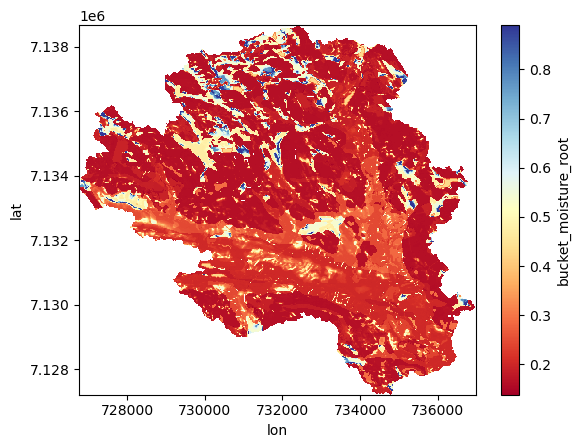

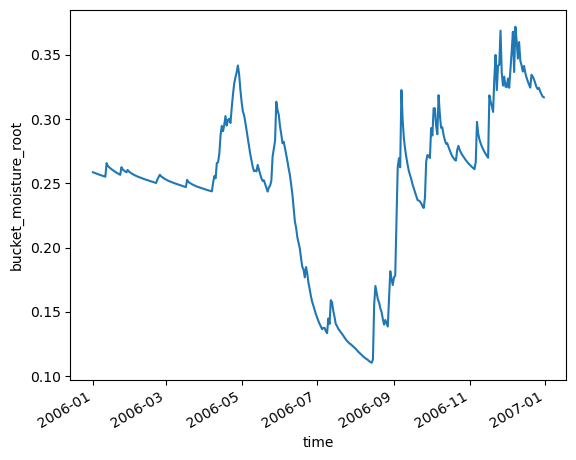

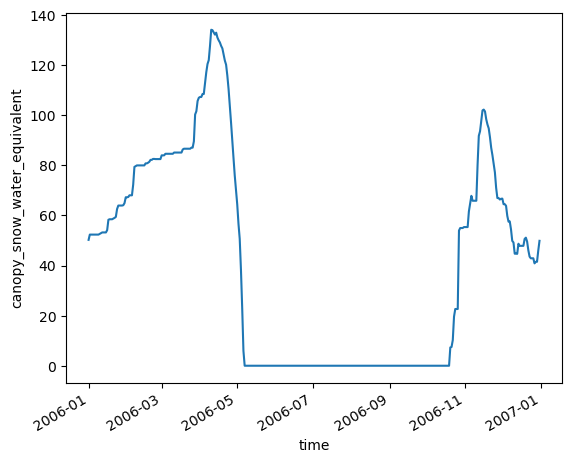

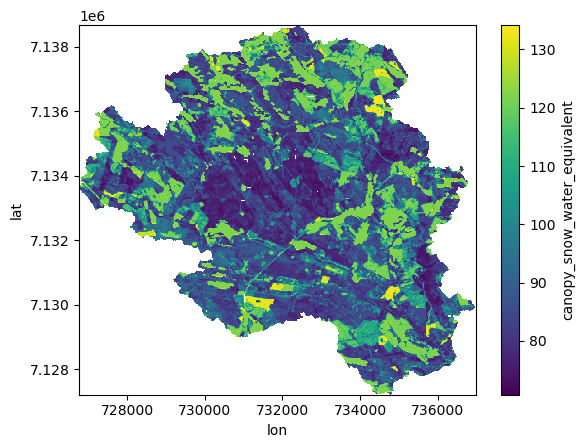

In [9]:
# Plotting example results
plt.figure(1)
results['bucket_moisture_root'].mean(dim='time').plot(cmap='RdYlBu')
plt.figure(2)
results['bucket_moisture_root'].mean(dim=['lat','lon']).plot()
plt.figure(3)
results['canopy_snow_water_equivalent'].max(dim=['lat','lon']).plot()
plt.figure(4)
results['canopy_snow_water_equivalent'].max(dim=['time']).plot()